<a id='start'></a>
# Implementazione di un algoritmo di classificazione con ML

In questo esercizio implementeremo una semplice rete neurale a 3 strati da zero. Non ricaveremo tutta la matematica necessaria, ma cercherò di dare una spiegazione intuitiva di ciò che stiamo facendo e indicherò le risorse per leggere i dettagli.

Ma perché implementare una rete neurale da zero? Anche se pianifichi di utilizzare le librerie di Reti Neurale come [PyBrain] (http://pybrain.org) in futuro, implementare una rete da zero almeno una volta è un esercizio estremamente prezioso. Ti aiuta a capire come funzionano le reti neurali, ed è essenziale per progettare modelli efficaci.

Una cosa da notare è che gli esempi di codice qui non sono molto efficienti. Sono pensati per essere facili da capire. <br>
<br>
Il notebook è suddiviso nelle seguenti sezioni:<br>
- [Generiamo il dataset](#section1)
- [Logistic Regression](#section2)
- [Addestriamo la Rete Neurale](#section3)
	- [Come la nostra rete realizza delle predizioni](#section3-1)
	- [Apprendere i parametri](#section3-2)
- [Implementazione](#section4)
	- [Una rete deep con 3 layer nascosti](#section4-1)
	- [Variamo la dimensione dei layer nascosti](#section4-2)

<a id='section1'></a>
## Generiamo il dataset

Iniziamo generando un set di dati con cui possiamo giocare. Fortunatamente [scikit-learn] (http://scikit-learn.org/) ha alcuni utili generatori di set di dati, quindi non abbiamo bisogno di scrivere il codice da soli. Usiamo la funzione [`make_moons`] (http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html).

In [1]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib

# Display plots inline and change default figure size
%matplotlib inline

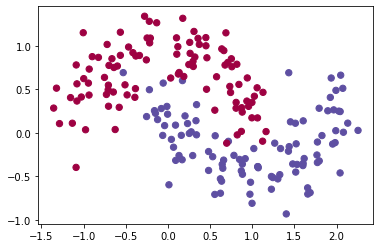

In [2]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

Il dataset che abbiamo generato ha due classi, tracciate come punti rossi e blu. Puoi pensare ai punti blu come a pazienti di sesso maschile e ai punti rossi come pazienti di sesso femminile, con l'asse X e Y come misure mediche.

Il nostro obiettivo è di formare un classificatore Machine Learning che preveda la classe corretta (maschio o femmina) in base alle coordinate x e y. Si noti che i dati non sono *linearmente separabili*, non è possibile tracciare una linea retta che separi le due classi. Ciò significa che i classificatori lineari, come Regressione logistica, non saranno in grado di adattare i dati a meno che non si gestiscano manualmente caratteristiche non lineari (come i polinomi) che funzionano bene per il set di dati specificato.

In effetti, questo è uno dei principali vantaggi delle reti neurali. Non devi preoccuparti di [ingegnerizzare le feature](http://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/). Lo strato nascosto di una rete neurale imparerà le funzionalità per te.

<a id='section2'></a>
## Logistic Regression

Per dimostrare il punto formiamo un classificatore di regressione logistica. Il suo input saranno i valori xey e l'output la classe prevista (0 o 1). Per semplificare la nostra vita usiamo la lezione di regressione logistica da `scikit-learn`.

In [3]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV(cv=4)
clf.fit(X, y)

LogisticRegressionCV(cv=4)

In [4]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot below.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

Text(0.5, 1.0, 'Logistic Regression')

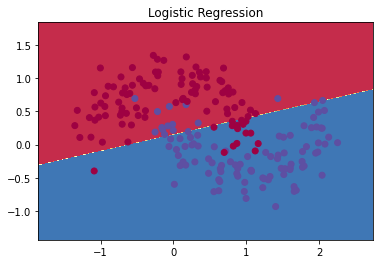

In [5]:
# Plot the decision boundary
plot_decision_boundary(lambda x: clf.predict(x))
plt.title("Logistic Regression")

Il grafico mostra il limite di decisione appreso dal nostro classificatore di regressione logistica. Separa i dati nel modo migliore possibile utilizzando una linea retta, ma non è in grado di catturare la "forma lunare" dei nostri dati.

<a id='section3'></a>
## Addestriamo la Rete Neurale

Costruiamo ora una rete neurale a 3 strati con un livello di input, un livello nascosto e un livello di output. Il numero di nodi nel livello di input è determinato dalla dimensionalità dei nostri dati, 2.

Analogamente, il numero di nodi nel livello di output è determinato dal numero di classi che abbiamo, ancora 2. (Poiché abbiamo solo 2 classi potrebbe effettivamente farla franca con un solo nodo di output che prevede 0 o 1, ma avere 2 rende più semplice estendere la rete a più classi in seguito).

L'input alla rete sarà le coordinate x e y e il suo output sarà due probabilità, una per la classe 0 ("femmina") e una per la classe 1 ("maschio").

Viene quindi qualcosa del genere:

<img src='img/nn-from-scratch-3-layer-network-1024x693.png' style='width: 80%'/>

Possiamo scegliere la dimensionalità (il numero di nodi) del livello nascosto. Più nodi inseriamo nello strato nascosto le funzioni più complesse che saremo in grado di adattare. Ma una maggiore dimensionalità ha un costo. Innanzitutto, sono necessari più calcoli per fare previsioni e imparare i parametri di rete. Un numero maggiore di parametri significa anche che diventiamo più inclini a sovraperformare i nostri dati.

Come scegliere la dimensione del livello nascosto? Mentre ci sono alcune linee guida e raccomandazioni generali, dipende sempre dal tuo problema specifico ed è più un'arte che una scienza. In seguito giocheremo con il numero di nodi nel livello nascosto e vediamo come influisce sul nostro output.

Dobbiamo anche scegliere una *funzione di attivazione* per il nostro livello nascosto. La funzione di attivazione trasforma gli input del layer nelle sue uscite. Una funzione di attivazione non lineare è ciò che ci consente di adattare ipotesi non lineari. Chocies comuni per le funzioni di attivazione sono [tanh] (https://reference.wolfram.com/language/ref/Tanh.html), [funzione sigmoid] (https://en.wikipedia.org/wiki/Sigmoid_function), o [ReLUs] (https://en.wikipedia.org/wiki/Rectifier_ (neural_networks). Useremo `tanh`, che si comporta abbastanza bene in molti scenari.Una buona proprietà di queste funzioni è che la loro derivata può essere calcolata utilizzando il valore della funzione originale.Ad esempio, la derivata di $ \ tanh x $ è $ 1- \ tanh ^ 2 x $. Ciò è utile perché ci consente di calcolare $ \ tanh x $ una volta e riutilizzare il suo valore più tardi per ottenere la derivata.

Poiché vogliamo che la nostra rete generi probabilità, la funzione di attivazione per il livello di output sarà [softmax] (https://en.wikipedia.org/wiki/Softmax_function), che è semplicemente un modo per convertire i punteggi grezzi in probabilità. Se hai familiarità con la funzione logistica, puoi pensare a softmax come alla sua generalizzazione a più classi.

<a id='section3-1'></a>
### Come la nostra rete realizza delle predizioni

La nostra rete fa previsioni usando *forward propagation*, che è solo un mucchio di moltiplicazioni di matrice e l'applicazione delle funzioni di attivazione che abbiamo definito sopra. Se $ x $ è l'input bidimensionale della nostra rete, calcoliamo la nostra previsione $\hat{y}$ (anche bidimensionale) come segue:

$$
\begin{aligned}
z_1 & = xW_1 + b_1 \\
a_1 & = \tanh(z_1) \\
z_2 & = a_1W_2 + b_2 \\
a_2 & = \hat{y} = \mathrm{softmax}(z_2)
\end{aligned}
$$

$z_i$ è la somma ponderata degli input del layer $i$ (bias incluso) e $a_i$ è l'output del layer $i$ dopo aver applicato la funzione di attivazione. $W_1, b_1, W_2, b_2$ sono parametri della nostra rete, che dobbiamo imparare dai nostri dati di addestramento. Puoi considerarli come matrici che trasformano i dati tra i vari livelli della rete. Osservando le moltiplicazioni della matrice sopra possiamo capire la dimensionalità di queste matrici. Se utilizziamo 500 nodi per il nostro livello nascosto, $W_1 \in \mathbb{R}^{2\times500}$, $b_1\in\mathbb{R}^{500}$, $W_2\in\mathbb{R}^{500\times2}$, $b_2\in\mathbb{R}^{2}$. Ora capisci perché abbiamo più parametri se aumentiamo le dimensioni del livello nascosto.

<a id='section3-2'></a>
### Apprendere i parametri

Imparare i parametri per la nostra rete significa trovare parametri ($ W_1, b_1, W_2, b_2 $) che riducano al minimo l'errore sui nostri dati di allenamento. Ma come definiamo l'errore? Chiamiamo la funzione che misura il nostro errore la funzione * loss *. Una scelta comune con l'output di softmax è la [Cross Entropy loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression). Se abbiamo $ N $ di training e $ C $, la perdita per la nostra previsione $ \ hat {y} $ rispetto alle vere etichette $ y $ è data da:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$



La formula sembra complicata, ma tutto ciò che realmente fa è sommare i nostri esempi di addestramento e aggiungere alla perdita se abbiamo previsto la classe sbagliata. Quindi, più lontano $ y $ (le etichette corrette) e $ \ hat {y} $ (le nostre previsioni), maggiore sarà la nostra perdita.

Ricorda che il nostro obiettivo è trovare i parametri che riducono al minimo la nostra funzione di perdita. Possiamo usare [gradiente di discesa](http://cs231n.github.io/optimization-1/) per trovare il minimo. Implementerò la versione più vanigliata della discesa del gradiente, chiamata anche discesa del gradiente batch con un tasso di apprendimento fisso. Variazioni come la discesa SGD (gradiente stocastico) o la discesa con gradiente di minibatch in genere hanno prestazioni migliori nella pratica. Quindi, se sei serio, vorrai usare uno di questi, e idealmente anche [decaderai il tasso di apprendimento nel tempo](http://cs231n.github.io/neural-networks-3/#anneal).

Come input, la discesa del gradiente richiede i gradienti (vettore di derivate) della funzione di perdita rispetto ai nostri parametri: $\frac{\partial{L}}{\partial{W_1}}$, $\frac{\partial{L}}{\partial{b_1}}$, $\frac{\partial{L}}{\partial{W_2}}$, $\frac{\partial{L}}{\partial{b_2}}$. Per calcolare questi gradienti usiamo il famoso *algoritmo di backpropagation*, che è un modo per calcolare in modo efficiente i gradienti a partire dall'output. Non andrò nei dettagli come funziona il backpropagation, ma ci sono molte spiegazioni eccellenti ([qui](http://colah.github.io/posts/2015-08-Backprop/) o [qui](http: // cs231n.github.io/optimization-2/)) fluttuante nel web.

Applicando la formula di backpropagation troviamo quanto segue (credimi su questo):

$$
\begin{aligned}
& \delta_3 = \hat{y} - y \\
& \delta_2 = (1 - \tanh^2z_1) \circ \delta_3W_2^T \\
& \frac{\partial{L}}{\partial{W_2}} = a_1^T \delta_3  \\
& \frac{\partial{L}}{\partial{b_2}} = \delta_3\\
& \frac{\partial{L}}{\partial{W_1}} = x^T \delta_2\\
& \frac{\partial{L}}{\partial{b_1}} = \delta_2 \\
\end{aligned}
$$

<a id='section4'></a>
## Implementazione

Ora siamo pronti per la nostra implementazione. Iniziamo definendo alcune variabili e parametri utili per la discesa del gradiente:

In [6]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

# Gradient descent parameters (I picked these by hand)
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

Per prima cosa implementiamo la funzione di perdita che abbiamo definito sopra. Lo usiamo per valutare l'efficacia del nostro modello:

In [7]:
# Helper function to evaluate the total loss on the dataset
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    
    return 1./num_examples * data_loss

Implementiamo anche una funzione di supporto per calcolare l'output della rete. Propaga la propagazione come sopra definito e restituisce la classe con la più alta probabilità.

In [8]:
# Helper function to predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    return np.argmax(probs, axis=1)

Infine, ecco la funzione per addestrare la nostra rete neurale. Implementa la discesa del gradiente discontinuo usando i derivati di backpropagation che abbiamo trovato sopra.

In [9]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, num_passes=20000, print_loss=False):
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):
        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
          print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
    
    return model

<a id='section4-1'></a>
### Una rete deep con 3 layer nascosti

Vediamo cosa succede se addestriamo una rete con una dimensione del livello nascosta di 3.


Loss after iteration 0: 0.432387
Loss after iteration 1000: 0.068947
Loss after iteration 2000: 0.068981
Loss after iteration 3000: 0.071218
Loss after iteration 4000: 0.071253
Loss after iteration 5000: 0.071278
Loss after iteration 6000: 0.071293
Loss after iteration 7000: 0.071303
Loss after iteration 8000: 0.071308
Loss after iteration 9000: 0.071312
Loss after iteration 10000: 0.071314
Loss after iteration 11000: 0.071315
Loss after iteration 12000: 0.071315
Loss after iteration 13000: 0.071316
Loss after iteration 14000: 0.071316
Loss after iteration 15000: 0.071316
Loss after iteration 16000: 0.071316
Loss after iteration 17000: 0.071316
Loss after iteration 18000: 0.071316
Loss after iteration 19000: 0.071316


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

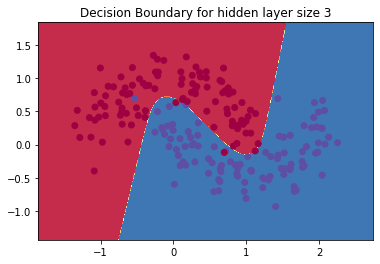

In [10]:
# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

Sìì! Questo sembra abbastanza buono. Le nostre reti neurali sono state in grado di trovare un limite decisionale che separa con successo le classi.

<a id='section4-2'></a>
### Variamo la dimensione dei layer nascosti

Nell'esempio sopra abbiamo scelto una dimensione del livello nascosta di 3. Ora diamo un'idea di come la variazione della dimensione del livello nascosto influisce sul risultato.


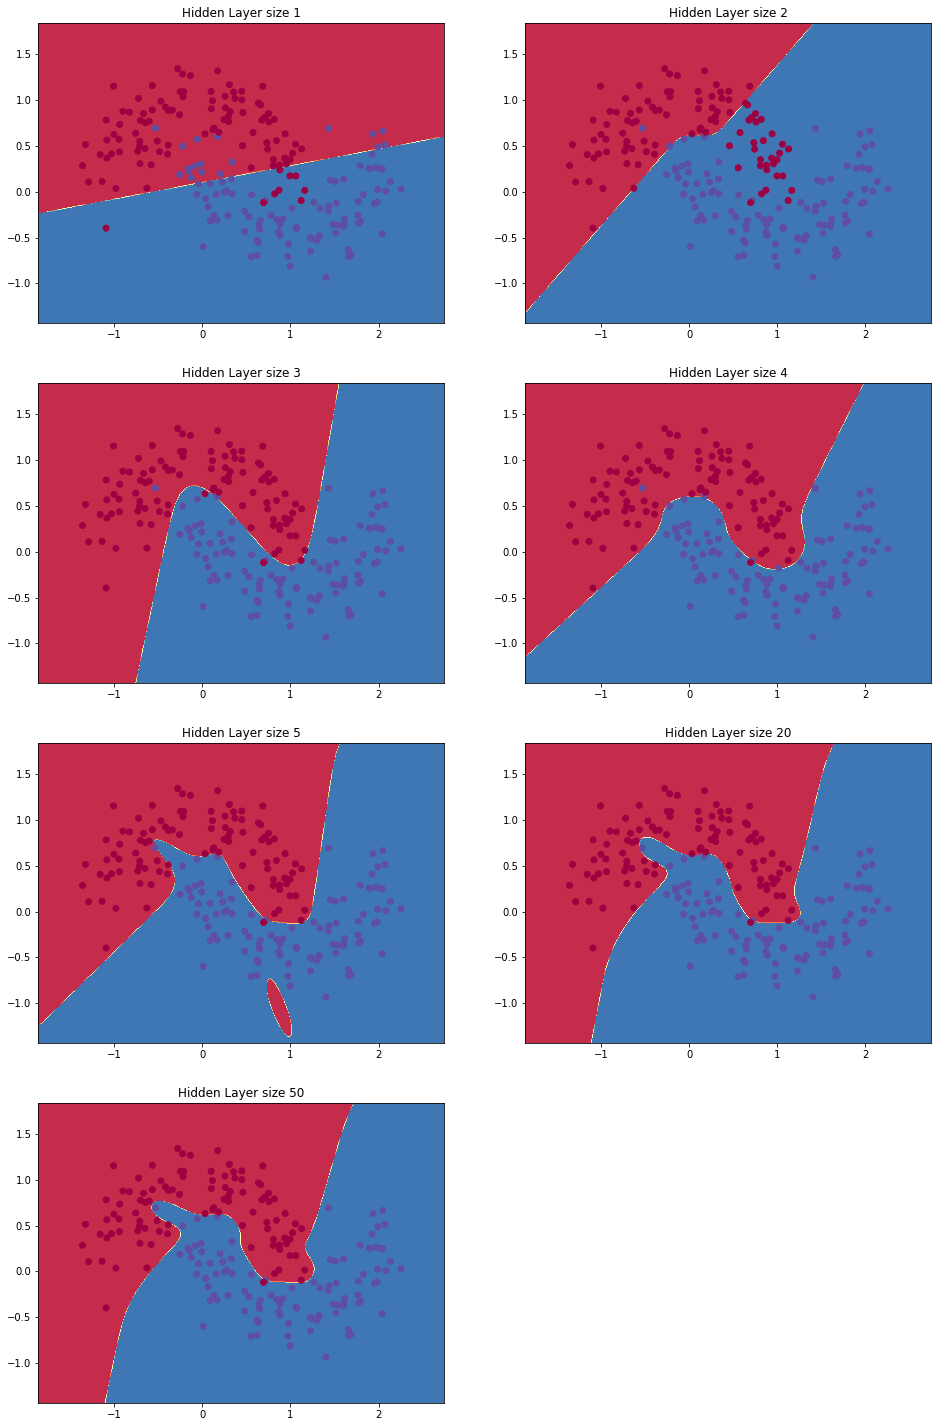

In [11]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 50]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(nn_hdim)
    plot_decision_boundary(lambda x: predict(model, x))
plt.show()

Possiamo vedere che mentre uno strato nascosto di bassa dimensionalità cattura bene la tendenza generale dei nostri dati, ma le dimensioni più elevate sono inclini al sovradattamento. Stanno "memorizzando" i dati anziché adattarli alla forma generale. Se dovessimo valutare il nostro modello su un set di test separato (e dovresti farlo!), Il modello con una dimensione di uno strato nascosto più piccolo probabilmente funzionerebbe meglio perché generalizza meglio. Potremmo contrastare l'overfitting con una maggiore regolarizzazione, ma scegliere la dimensione corretta per lo strato nascosto è una soluzione molto più "economica".

[Clicca qui per tornare all'inizio della pagina](#start)<a id='start'></a>